# Newton’s method and nonlinear equations

In first-year calculus, most students learn [Newton’s method](https://en.wikipedia.org/wiki/Newton's_method) for solving nonlinear equations $f(x) = 0$, which iteratively improves a sequence of guesses for the solution $x$ by **approximating f by a straight line**.   That is, it **approximates a *nonlinear* equation by a sequence of approximate *linear* equations**.

This can be extended to *systems* of nonlinear equations as a **multidimensional Newton** method, in which we iterate by solving a sequence of linear (*matrix*) systems of equations.  This is one example of an amazing fact: **linear algebra is a fundamental tool even for solving nonlinear equations**.

## Packages for this notebook

In [1]:
# Pkg.add.(["Interact", "PyPlot", "ForwardDiff"]) # uncomment this line to install packages
using Interact, PyPlot

In [2]:
# workaround for Anaconda library-path bug (https://github.com/JuliaPy/PyPlot.jl/issues/315)
import PyCall
if is_apple() && PyCall.conda
    libdir = dirname(PyCall.libpython)
    Libdl.dlopen_e(joinpath(libdir, "libiomp5.dylib"))
    Libdl.dlopen_e(joinpath(libdir, "libmkl_intel_thread.dylib"))
end

Ptr{Void} @0x00007ff778469e30

## One-dimensional Newton

The standard one-dimensional Newton’s method proceeds as follows.  Suppose we are solving for a zero (root) of $f(x)$:

$$
f(x) = 0
$$

for an arbitrary (but differentiable) function $f$, and we have a guess $x$.   We find an *improved* guess $x+\delta$ by [Taylor expanding](https://en.wikipedia.org/wiki/Taylor_series) $f(x+\delta)$ around $x$ to *first order* (linear!) in $\delta$, and finding the .  (This should be accurate if $x$ is *close enough* to a solution, so that the $\delta$ is *small*.)  That is, we solve:

$$
f(x + \delta) \approx f(x) + f'(x) \delta = 0
$$

to obtain $\delta = -f(x) / f'(x)$.  Plugging this into $x+\delta$, we obtain:

$$
\boxed{\mbox{new } x = x - f(x)/f'(x)}.
$$

This is called a **Newton step**.  Then we simply repeat the process.

Let's visualize this process for finding a root of $f(x) = 2\cos(x) - x + x^2/10$ (a [transcendental equation](https://en.wikipedia.org/wiki/Transcendental_equation) that has no closed-form solution).

Interact.Slider{Int64}(1: "input" = 1 Int64 , "", 1, 1:20, "horizontal", true, "d", true)

Interact.Slider{Float64}(3: "input-2" = -0.1 Float64 , "", -0.1, -4.0:0.1:4.0, "horizontal", true, ".3f", true)

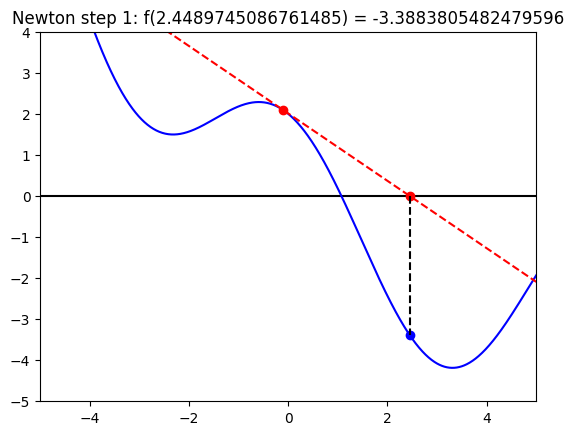

In [3]:
fig = figure()
xs = linspace(-5,5,1000)
@manipulate for step in slider(1:20, value=1), start in slider(-4:0.1:4, value=-0.1)
    withfig(fig) do
        x = start
        local xprev, f, f′
        for i = 1:step
            xprev = x
            f = 2cos(x) - x + x^2/10
            f′ = -2sin(x) - 1 + 2x/10
            x = x - f/f′
        end
        plot(xs, 0*xs, "k-")
        plot(xs, 2cos.(xs) - xs + xs.^2/10, "b-")
        newf = 2cos(x) - x + x^2/10
        plot([xprev, x], [f, 0.0], "ro")
        plot(x, newf, "bo")
        plot(xs, f + f′ * (xs - xprev), "r--")
        plot([x, x], [0, newf], "k--")
        xlim(minimum(xs), maximum(xs))
        ylim(-5,4)
        title("Newton step $step: f($x) = $newf")
    end
end

If you start it anywhere near a root of $f(x)$, Newton’s method can converge extremely quickly: **asymptotically, it doubles the number of accurate digits on each step**.

However, if you start it far from a root, the convergence can be hard to predict, and it may not even converge at all (it can oscillate forever around a local minimum).

Still, in many practical applications, there are ways to get a good initial guess for Newton, and then it is an extremely effective way to solve nonlinear equations to high accuracy.

## General Multidimensional Newton

The general case of the multidimensional Newton algorithm is as follows.  We are solving:

$$
\begin{pmatrix}
f_1(x_1, \ldots, x_n) \\
f_2(x_1, \ldots, x_n) \\
\vdots \\
f_n(x_1, \ldots, x_n)
\end{pmatrix}
= f(x) = 0
$$

for $x \in \mathbb{R}^n$ and $f(x) \in \mathbb{R}^n$: $n$ (possibly nonlinear but differentiable) equations in $n$ unknowns.

Given a guess $x$, we want to find an improved guess $x + \delta$ for $\delta \in \mathbb{R}^n$.   We do this by Taylor-expanding $f$ around $x$ to first order (linear):

$$
f(x + \delta) \approx f(x) + J(x) \, \delta  = 0
$$

where $J$ is the $n \times n$ Jacobian matrix with entries $\boxed{ J_{ij} = \partial f_i / \partial x_j }$, i.e.

$$
J = \begin{pmatrix}
\frac{\partial f_1}{\partial x_1} & \frac{\partial f_1}{\partial x_2} & \cdots \\
\frac{\partial f_2}{\partial x_1} & \frac{\partial f_2}{\partial x_2} & \cdots \\
\vdots & \vdots & \ddots
\end{pmatrix} \; .
$$

Hence, we solve the *linear* equation

$$
J(x) \, \delta = -f(x)
$$

for the Newton step $\delta$, obtaining (if $J$ is invertible):

$$
\boxed{ x + \delta = x - J(x)^{-1} f(x) }
$$

Some things to remember:

* Newton converts $n$ *nonlinear* equations into repeated solution of $n \times n$ *linear* equations.

* When solving nonlinear equations, coming up with a good initial guess is a bit of an art, that often requires some problem-specific understanding.  A typical trick is to solve a related problem, e.g. a linear problem.  Or to start with a linear problem and to "turn on" the nonlinearity gradually, using the solution of each nonlinear problem as the starting guess for the next one.

* If you start too far from a root, Newton’s method can sometimes take a large step, far outside the validity of the Taylor approximation, and this can actually make the guess *worse*.  Sophisticated implementations use a variety of techniques to make the convergence more robust, such as a [backtracking line search](https://en.wikipedia.org/wiki/Backtracking_line_search) or a [trust region](https://en.wikipedia.org/wiki/Trust_region).  These techniques are outside the scope of 18.06, though!

* There are other methods related to Newton that don't require you to compute $J(x)$ at all.  You only supply $f(x)$ and they either approximate the Jacobian for you directly (e.g. [Broyden’s method](https://en.wikipedia.org/wiki/Broyden's_method)) or implicitly (e.g. [Anderson acceleration](http://epubs.siam.org/doi/abs/10.1137/10078356X)).  There is a rich mathematical literature on solution methods for nonlinear systems of equations, but essentially all the methods have one thing in common: *linear* algebra plays a key role.

## Automatic differentiation

Computing the Jacobian, while in principle is a simple 18.02 exercise, is often tedious and error prone for large systems of equations.

Instead, the Jacobian matrix can often be *automatically* computed from $f(x)$ by the computer using [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) tools, saving you from the tedious (and error-prone) task of writing out $J(x)$ manually.  (How this works, involving [dual numbers](https://en.wikipedia.org/wiki/Dual_number), is [really cool](https://arxiv.org/abs/1607.07892), but somewhat outside the scope of 18.06.)

In Julia, there are packages [ForwardDiff](https://github.com/JuliaDiff/ForwardDiff.jl) and [ReverseDiff](https://github.com/JuliaDiff/ReverseDiff.jl) to do this for you.

For example, let's compute the Jacobian for $$f_\mathrm{ex}(x) = \begin{pmatrix} \sin(x_1 x_2) - 0.5 \\ x_1^2 - x_2^2 \end{pmatrix}$$, which should give $$J_\mathrm{ex}(x) = \begin{pmatrix} x_2 \cos(x_1 x_2) & x_1 \cos(x_1 x_2) \\ 2x_1 & -2x_2 \end{pmatrix}$$:

In [4]:
fₑₓ(x) = [ sin(x[1]*x[2]) - 0.5
        x[1]^2 - x[2]^2 ]

# manual Jacobian
Jₑₓ(x) = [ x[2]*cos(x[1]*x[2])  x[1]*cos(x[1]*x[2])
         2x[1]               -2x[2]               ]

Jₑₓ (generic function with 1 method)

In [5]:
fₑₓ([2,3])

2-element Array{Float64,1}:
 -0.779415
 -5.0     

In [6]:
Jₑₓ([2,3]) # manual Jacobian

2×2 Array{Float64,2}:
 2.88051   1.92034
 4.0      -6.0    

In [7]:
using ForwardDiff

In [8]:
ForwardDiff.jacobian(fₑₓ, [2,3]) # automatic Jacobian

2×2 Array{Float64,2}:
 2.88051   1.92034
 4.0      -6.0    

In [9]:
ForwardDiff.jacobian(fₑₓ, [2,3]) - Jₑₓ([2,3])

2×2 Array{Float64,2}:
 0.0  0.0
 0.0  0.0

## Multidimensional root finding example

As a simple example, let's find a root of our test function
$$f_\mathrm{ex}(x) = \begin{pmatrix} \sin(x_1 x_2) - 0.5 \\ x_1^2 - x_2^2 \end{pmatrix}$$
from above.

We can actually solve this analytically. $f_\mathrm{ex}(x) = 0$ immediately tells us $x_1 = \pm x_2$ from $x_1^2 - x_2^2 = 0$.  If we let $x = x_1 = x_2$, then $\sin(x^2) - 0.5$ has its first root at $x = \sqrt{\pi/6}$.   We can also see these roots graphically by plotting:

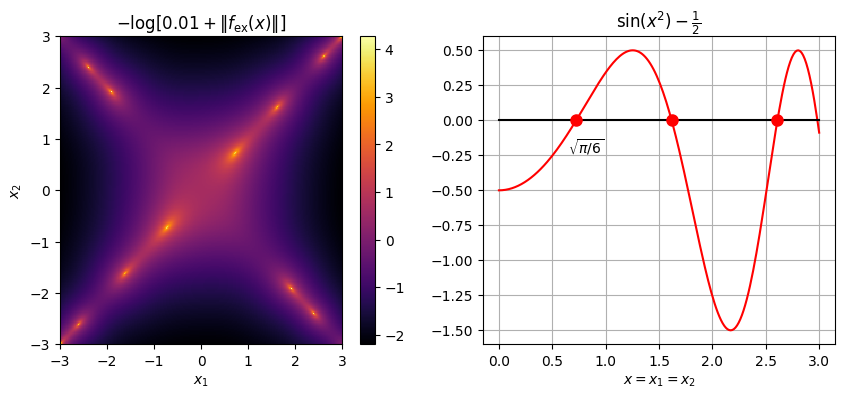

In [10]:
figure(figsize=(10,4))

subplot(1,2,1)
X = linspace(-3,3,250)
pcolor(X', X, [-log(0.01 + norm(fₑₓ([x,y]))) for y in X, x in X], cmap="inferno")
xlabel(L"x_1")
ylabel(L"x_2")
title(L"-\log [ 0.01 + \Vert f_\mathrm{ex}(x) \Vert]")
colorbar()

subplot(1,2,2)
x = linspace(0,3,200)
plot(x, sin.(x.^2) .- 0.5, "r-")
plot(x, 0*x, "k-")
plot([sqrt(pi/6), sqrt(5pi/6), sqrt(13pi/6)], [0,0,0], "ro", markersize=8)
text(0.65, -0.23, L"\sqrt{\pi/6}")
title(L"\sin(x^2) - \frac{1}{2}")
xlabel(L"x = x_1 = x_2")
grid()

Here is the coordinate of our first root:

In [11]:
sqrt(π/6)

0.7236012545582676

Let's print out the progress after varying numbers of Newton steps starting at a crude initial guess $x = \begin{pmatrix} 0.5 \\ 0.8 \end{pmatrix}$:

In [12]:
x = [0.5, 0.8]
for i = 1:10
    x = x - J(x) \ f(x)  # Newton step
    println("$i Newton steps: x = $x, f(x) = ", f(x))
end

LoadError: [91mUndefVarError: J not defined[39m

As usual, super fast convergence: **15 decimal places in only four steps!**

## A nonlinear circuit problem

Consider the nonlinear circuit graph from the [graphs and networks lecture](http://nbviewer.jupyter.org/github/stevengj/1806-spring17/blob/master/lectures/Graphs-Networks.ipynb):

<img src="https://github.com/stevengj/1806-spring17/raw/master/lectures/circuit.png" width="300">

The incidence matrix $A$ of this graph is:

In [13]:
A = [ -1   0   0   1   0   0
       0   0   0  -1   1   0
       0   0   0   0  -1   1
       0   0   1   0   0  -1
       0   1  -1   0   0   0
       1  -1   0   0   0   0
       0  -1   0   0   0   1
       0   0   0  -1   0   1 ]

8×6 Array{Int64,2}:
 -1   0   0   1   0   0
  0   0   0  -1   1   0
  0   0   0   0  -1   1
  0   0   1   0   0  -1
  0   1  -1   0   0   0
  1  -1   0   0   0   0
  0  -1   0   0   0   1
  0   0   0  -1   0   1

### Review: (Linear) circuit equations

Recall that if we associate a vector $v$ of voltages with the 6 nodes, then $d = Av$ gives the **voltage rise** across each edge, and $i = -YAv$ gives the **current** through each edge, where $Y$ is a diagonal matrix of admittances (= 1/resistance)

$$
Y = \begin{pmatrix} Y_1 &     &        &     \\
                        & Y_2 &        &     \\
                        &     & \ddots &     \\
                        &     &        & Y_8 \\
    \end{pmatrix}
$$

This is simply an expression of Ohm's law.

Furthermore, we showed that Kirchhoff’s current law is just the statement $A^T i = 0$.   Putting it all together, and including a current source term $s$ (an external current flowing out of each node), we obtained the equations:

$$
A^T Y A v = s
$$

where to have a solution ($A^T Y A$ is singular) we had to have $s \perp N(A)$, or equivalently $\sum_i s_i = 0$: the net current flowing in/out of the circuit must be zero.

### Nonlinear Ohm’s law

A key physical foundation of the equations above was Ohm’s law: $i_j = -d_j/R_j = - Y_j d_j$, which is the statement that the **current is proportional to the voltage drop** $-d_j$.

However, this is only an approximation.  In reality, as the voltage and current increase, the resistance changes.  For example, the resistor heats up (and eventually melts!) due to the dissipated power $i_j^2 / Y_j = Y_j d_j^2$, and resistance depends on temperature.

Let's try a **simple model** of a voltage-dependent resistance.  Suppose that we modify Ohm’s law to:

$$
i_j = - \underbrace{ \frac{Y_j }{1 + \alpha_j d_j^2} }_{\tilde{Y}_j(d_j)} d_j
$$

where $\tilde{Y}_j(d_j) = Y_j / (1 + \alpha_j d_j^2)$ corresponds to a resistance that increases quadratically with the voltage rise $d_j$.  This model is not unrealistic!   For a real resistor, you could measure the voltage dependence of $Y$, and *fit* it to an equation of this form, and it would be valid for sufficiently small $d_j$!  (The admittance will normally only depend on $d^2$, not on $d$, because with most materials it will not depend on the sign of the voltage drop or current.)

The problem, of course, is that with this nonlinear Ohm’s law, the whole problem becomes a **nonlinear system of equations**.  How can we solve such a system of equations?  At first glance, the methods of 18.06 don't work — they are only for *linear* systems.

But, we can apply Newton's method as described above, with automatic differentiation via `ForwardDiff`, to solve this by a sequence of linear problems.

#### Example

For an example, let's just set $Y_k = 1$ and $\alpha_k = 0.5$ for $k=1,\ldots,6$, and use $s = (1,-1,0,0,0,0)$ as in the previous lecture (current injected into node 2 and extracted out from node 1).

What should we use as our initial guess?  How about the solution to the *linear* problem with $\tilde{Y}(0) = Y$?  That's often a good guess, since in many real problems the nonlinear solution will be very close to the solution of a simplified linear problem.

Let's write some code to compute $f(v)$ and $J(v)$:

In [14]:
Yₖ = 1
αₖ = 0.5
Ỹₖ(d) = Yₖ / (1 + αₖ * d^2)

f(v) = A' * (diagm(Ỹₖ.(A*v)) * (A*v)) - [1,-1,0,0,0,0]
J(v) = ForwardDiff.jacobian(f, v)

J (generic function with 1 method)

Now let's implement the Newton step $v - J(v)^{-1} f(v)$.

I'd ideally like to use `v - J(v) \ f(v)` in Julia,
but the ``` \ ``` function will complain that `J` is singular, even though `f` is in the column space as discussed below.  There are various ways to do this properly numerically, but for simplicity I will "cheat" and use and advanced tool called the [pseudo-inverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_pseudoinverse), computed in julia by `pinv(J)`, which (for a right-hand-side in the column space) will give us a particular solution similar to what we would get from the elimination technique we learned in class.   (We will cover the pseudo-inverse much later in 18.06.)  There are other ways to proceed here that are even more efficient, but `pinv` is the simplest.

In [15]:
newtonstep(v) = v - pinv(J(v)) * f(v)

newtonstep (generic function with 1 method)

Now, let's see what happens.  We'll start by just plotting the voltages as a function of the Newton step, to see how (and whether) it is converging:

In [16]:
function newton(v, nsteps)
    for i = 1:nsteps
        v = newtonstep(v)
    end
    return v
end
newton(v, nsteps::AbstractVector) = map(n -> newton(v,n), nsteps)

newton (generic function with 2 methods)

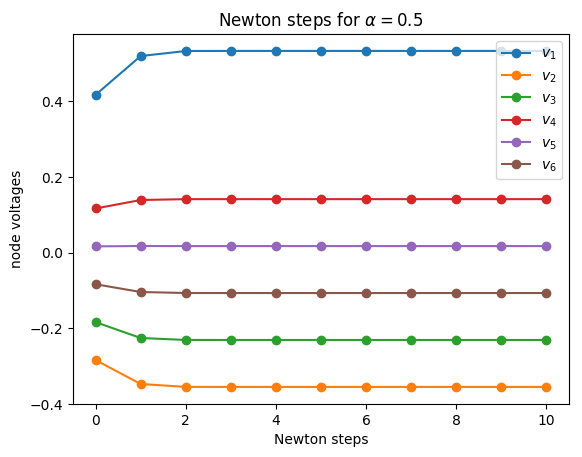

PyObject <matplotlib.text.Text object at 0x14a23c510>

In [17]:
M₀ = A' * diagm(Ỹₖ.(zeros(8))) * A # matrix AᵀYA for zero voltage drops (i.e. linear problem)
v₀ = pinv(M₀) * [1,-1,0,0,0,0]  # initial guess = solution to linear problem
vsteps = newton(v₀, 0:10)
plot([vsteps[i][j] for i=1:length(vsteps), j=1:6], "o-")
xlabel("Newton steps")
ylabel("node voltages")
legend([L"v_1", L"v_2", L"v_3", L"v_4", L"v_5", L"v_6"], loc="upper right")
title(L"Newton steps for $\alpha = 0.5$")

Clearly, it is converging pretty rapidly.  Another way to see this is to plot the convergence of the length (norm) of the $f(v)$ vector, $\Vert f(v) \Vert = \sqrt{f(v)^T f(v)}$:

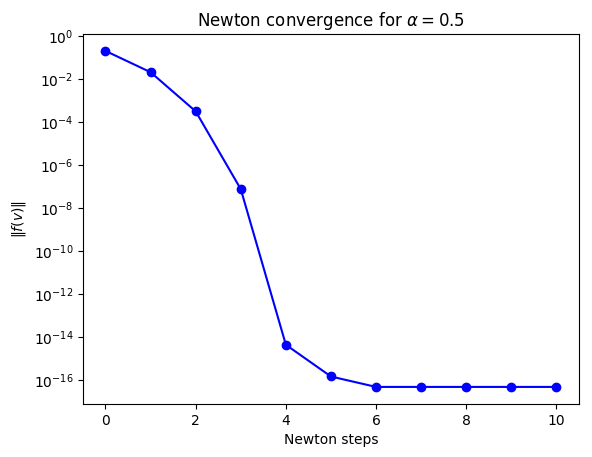

PyObject <matplotlib.text.Text object at 0x1281ba7d0>

In [18]:
xlabel("Newton steps")
ylabel(L"\Vert f(v) \Vert")
semilogy(norm.(f.(vsteps)), "bo-")
title(L"Newton convergence for $\alpha = 0.5$")

It converges **faster than exponentially** with the step.  Once it is close to the solution, Newton roughly **doubles the number of digits in each step**.

Eventually, it stops getting better: the accuracy is **limited by roundoff errors** once the error reaches $\approx 10^{-16}$, related to the fact that the computer is only doing arithmetic to about 16 digits of accuracy.

#### Computing the Jacobian manually

It might be nice to look more explicitly at the Jacobian matrix to understand why it is singular in this problem, and why that is okay here (i.e. why a solution exists).  In really large computational problems, people often compute Jacobians more explicitly in order to extract computational savings (by exploiting any special forms of the matrices in the analytical result).

It is also, unfortunatey, a lot messier and more error prone to compute the Jacobian manually.  I often like to think of the Jacobian in terms of Taylor expanding: if you **Taylor expand everything to first order**, throwing away higher-order terms, then the **Jacobian matrix is the coefficient of the 1st-order term** in the final result.

The admittance is written in terms of the voltage rise $d = Av$.  If we change $v$ to $v+\delta$, then we get $d + A\delta$.  Let's denote $\hat{\delta} = A\delta$.  Then the formula for each component of our current $i$ becomes:

$$
i_j = -\tilde{Y}_j(d_j +\hat{\delta}_j) \, (d_j +\hat{\delta}_j) \approx -\tilde{Y}_j(d_j) d_j - (\tilde{Y}_j(d_j) + \tilde{Y}_j'(d_j) d_j) \hat{\delta}_j
$$

where we have just Taylor-expanded around $\hat{\delta}_j = 0$, and $\tilde{Y}_j'(d_j) = -2 \alpha_j d_j Y_j / (1 + \alpha_j d_j^2)^2$.  Let $K_j(d_j) = \tilde{Y}_j(d_j) + \tilde{Y}_j'(d_j) d_j$, and then we have:

$$
i_j \approx - \left[ \tilde{Y}_j(d_j) d_j + K_j(d_j) \hat{\delta}_j \right]
$$

Plugging this into $f(v+\delta)$, we get

$$
f(v+\delta) \approx \underbrace{A^T Y(Av) Av - s}_{f(v)} + \underbrace{A^T K(Av) A}_{J(v)} \delta
$$

and hence

$$
J(v) = A^T K(Av) A
$$

where

$$
K(d) = \begin{pmatrix} K_1(d_1) &     &        &     \\
                        & K_2(d_2) &        &     \\
                        &     & \ddots &     \\
                        &     &        & K_8(d_8) \\
    \end{pmatrix}
$$

There is one slight problem here: $J$ is a singular matrix even if all $K_j \neq 0$, because of $N(A) \ne \{0\}$.   Just as with $s$, $J(v) y = f(v)$ only has a solution if $f(v) \in C(J) \subseteq C(A^T)$.  Fortunately, $f(v) = A^T Y A - s$ is *always* in $C(A^T)$ as long as $s \in C(A^T) = N(A)^\perp$, which was required *anyway* (from above) if we are to have a solution in the *linear* case.

(We can still run into a singular $J$ for "unlucky" $K_j$, but that is a typical hazard of Newton's method, just like we can run into $f'(x)=0$ for unlucky $x$ values.  The important thing is that it doesn't happen "generically", i.e. singularities only occur at isolated points.)

In [19]:
Ỹₖ′(d) = -2αₖ*d*Yₖ / (1 + αₖ * d^2)^2
Kₖ(d) = Ỹₖ(d) + Ỹₖ′(d)*d
J_manual(v) = A' * diagm(Kₖ.(A*v)) * A

J_manual (generic function with 1 method)

Let's check this against our automatic Jacobian:

In [20]:
v = [0.1,1.2,3.4,5.6,-0.3,0.7] # a "random" vector
ForwardDiff.jacobian(f, v)

6×6 Array{Float64,2}:
  0.0990134  -0.153337   0.0        0.0543237   0.0         0.0      
 -0.153337    0.72329    0.121405   0.0         0.0        -0.691358 
  0.0         0.121405  -0.243995   0.0         0.0         0.12259  
  0.0543237   0.0        0.0       -0.167821    0.0484289   0.0650683
  0.0         0.0        0.0        0.0484289   0.173793   -0.222222 
  0.0        -0.691358   0.12259    0.0650683  -0.222222    0.725922 

In [21]:
J_manual(v)

6×6 Array{Float64,2}:
  0.0990134  -0.153337   0.0        0.0543237   0.0         0.0      
 -0.153337    0.72329    0.121405   0.0         0.0        -0.691358 
  0.0         0.121405  -0.243995   0.0         0.0         0.12259  
  0.0543237   0.0        0.0       -0.167821    0.0484289   0.0650683
  0.0         0.0        0.0        0.0484289   0.173793   -0.222222 
  0.0        -0.691358   0.12259    0.0650683  -0.222222    0.725922 

In [22]:
ForwardDiff.jacobian(f, v) - J_manual(v)

6×6 Array{Float64,2}:
  5.55112e-17  -5.55112e-17   0.0          …   0.0           0.0        
 -5.55112e-17   0.0           0.0              0.0           0.0        
  0.0           0.0          -5.55112e-17      0.0           5.55112e-17
  0.0           0.0           0.0             -2.77556e-17   2.77556e-17
  0.0           0.0           0.0              2.77556e-17   0.0        
  0.0           0.0           5.55112e-17  …   0.0          -1.11022e-16

Yup, it computed our Jacobian automatically and perfectly accurately (up to the machine-precision rounding errors).

[How ForwardDiff works](https://arxiv.org/abs/1607.07892), based on [dual numbers](https://en.wikipedia.org/wiki/Dual_number), is outside the scope of 18.06, but there is a nice [tutorial notebook](http://nbviewer.jupyter.org/github/stevengj/18S096-iap17/blob/master/lecture8/Automatic%20differentiation%20and%20applications.ipynb) by [David Sanders](http://sistemas.fciencias.unam.mx/~dsanders/).